# Bigmart Sales Data Set

Retail is another industry which extensively uses analytics to optimize business processes. Tasks like product placement, inventory management, customized offers, product bundling, etc. are being smartly handled using data science techniques. As the name suggests, this data comprises of transaction records of a sales store. This is a regression problem. The data has 8523 rows of 12 variables.

<b>Problem</b>: Predict the sales of a store.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from classifiers import baseModel
from classifiers import LinearRegression
from classifiers import ClassicLinearRegression
from scipy import linalg
%load_ext autoreload
%autoreload 2

We have the training data in CSV format. First step is to read it in pandas dataframe

In [2]:
dataset =  pd.read_csv('Train_UWu5bXk.csv')
dataset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Data Munging
Now that we have the data in a dataset, first thing that we will do is check what all columns have missing values and come up with a way to impute these missing values

In [3]:
dataset.apply(lambda x:sum(x.isnull()),axis=0)

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Only two columns (Item_weight and Outlet_size) have missing values. 

### Outlet_Size 
Let's start with Outlet_size. A good strategy would be look at other feautres in the data and see if they can provide some clue to what could be the possible value for Outlet_size. The Outlet_type can be a good candidate to look at. The type of store should tell what the size of the outlet might be. 
<br><br>
Let's group the data on outlet type and see where all the missing values falls

In [4]:
dataset[dataset['Outlet_Size'].isnull()].groupby('Outlet_Type')['Outlet_Size'].apply(lambda x : sum(x.isnull())).reset_index()

,Outlet_Type,Outlet_Size
0,Grocery Store,555
1,Supermarket Type1,1855


So only outlet_type 'Grocery Store' and 'Supermarket Type 1' have missing values for outlet size. Let's see what is the dominent  value for outlet size is for these two type of outlets

In [5]:
pd.crosstab(dataset['Outlet_Type'],dataset['Outlet_Size'])

Outlet_Size,High,Medium,Small
Outlet_Type,,,
Grocery Store,0,0,528
Supermarket Type1,932,930,1860
Supermarket Type2,0,928,0
Supermarket Type3,0,935,0


All the Grocery Stores are of Small size. So it makes sens to update the missing values of outlet size for store type as Grocery Store as 'Small'
<br><br>
For Stores of type 'Supermarket Type 1' the dominent store size is Small. Although its not a clear indicator, it is unlikely to hurt the final prediction much if we assume that the missing store size for store type 'Supermarket Type 1' is Small.

In [6]:
dataset.loc[(dataset['Outlet_Type']=='Grocery Store') & (dataset['Outlet_Size'].isnull()),'Outlet_Size'] = 'Small'
dataset.loc[(dataset['Outlet_Type'] == 'Supermarket Type1') & (dataset['Outlet_Size'].isnull()),'Outlet_Size'] = 'Small'

### Item_weight
Next we will look at the item weights. Here again we will look at the other features in the data to impute missing values for the Item_weight column.
<br><br>
A simple strategy would be to look at the Item_type and Item_Fat_content and impute the missing value for item_weight with the avarage weight for the item of same type and with same fat content
<br><br>
But before we do that we need to clean the Item_fat_content values a bit. Lets see what all unique values are given for this column.

In [7]:
dataset['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

let us replace 'reg' with 'Regular'
<br>
and 'LF' & 'low fat' with 'Low Fat'

In [8]:
dataset.loc[(dataset['Item_Fat_Content']=='LF'),'Item_Fat_Content'] = 'Low Fat'
dataset.loc[(dataset['Item_Fat_Content']=='low fat'),'Item_Fat_Content'] = 'Low Fat'
dataset.loc[(dataset['Item_Fat_Content']=='reg'),'Item_Fat_Content'] = 'Regular'

Now we can fix the missing values for the Item_weight column

In [9]:
Item_Types = dataset['Item_Type'].unique()
for item_type in Item_Types:
    for fat_con in ['Regular','Low Fat']:
        mean_weight = dataset[(dataset['Item_Weight'].notnull())&
                             (dataset['Item_Type'] == item_type)&
                             (dataset['Item_Fat_Content'] == fat_con)]['Item_Weight'].mean()
        if np.isnan(mean_weight):
            continue
        dataset.loc[(dataset['Item_Weight'].isnull())&
               (dataset['Item_Type']==item_type)&
               (dataset['Item_Fat_Content'] == fat_con),'Item_Weight'] = mean_weight

### Outlet_Establishment_Year
This column contains the year when the outlet was established. As such it doesn't seems to be a helpful feature for a learning model. But we can create a new feature which can give a notion of the outlet age. Since it is fair to assume that age of store can potentially play a role in the over all sales from the store (older store may have steadier stream of customers then a new one), this new feature can be helpful for the learning model.
<br><br>
Let's calculate the Outlet_age column by subtracting value of Outlet_Establishment_Year from the max value of the column (which is 2009). 

In [10]:
dataset['outlet_age'] = dataset['Outlet_Establishment_Year'].max() - dataset['Outlet_Establishment_Year']

## Descriptive Analysis
Now as we have cleaned our data, we can do some Descriptive Analysis before we jump onto building Machine Learning Models

In [11]:
dataset = dataset[['Item_Identifier','Item_Weight','Item_Fat_Content','Item_Visibility','Item_Type','Item_MRP',
                  'Outlet_Identifier','outlet_age','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Outlet_Sales']]

<b>Top 10 Selling Items</b>
<br>
What are the top 10 selling Items?

In [12]:
dataset.groupby('Item_Identifier')['Item_Outlet_Sales'].sum().reset_index().sort_values('Item_Outlet_Sales',
                                                                                        ascending=False).head(10)

,Item_Identifier,Item_Outlet_Sales
1210,FDY55,42661.8008
156,FDA15,41584.5364
1230,FDZ20,40185.0248
359,FDF05,36555.7490
148,FDA04,35741.4756
544,FDK03,34843.9772
1454,NCQ06,34680.1904
1464,NCQ53,34508.4140
538,FDJ55,33531.0196
305,FDD44,32723.4042


<b>Top Selling Items in each store</b>
<br>
What are the top 10 selling Items in each store?

In [13]:
idx = dataset['Item_Outlet_Sales'] == dataset.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].transform(max)
dataset[idx][['Outlet_Identifier','Item_Identifier','Item_Outlet_Sales']].sort_values('Item_Outlet_Sales',ascending=False)

,Outlet_Identifier,Item_Identifier,Item_Outlet_Sales
7188,OUT027,NCE42,13086.9648
4888,OUT013,FDF39,10256.6490
4289,OUT046,NCM05,9779.9362
4961,OUT017,FDK03,9664.7528
8039,OUT045,FDY55,8994.9580
5752,OUT035,FDI15,8479.6288
1506,OUT049,FDB15,7646.0472
43,OUT018,FDC02,6768.5228
7759,OUT010,NCK30,1775.6886
8353,OUT019,NCX41,1482.0708


<b>Top 10 Selling item typese</b>
<br>
What are the top 10 selling Items types?

In [14]:
dataset.groupby('Item_Type')['Item_Outlet_Sales'].sum().reset_index().sort_values('Item_Outlet_Sales',
                                                                                 ascending=False).head(10)

,Item_Type,Item_Outlet_Sales
6,Fruits and Vegetables,2.820060e+06
13,Snack Foods,2.732786e+06
9,Household,2.055494e+06
5,Frozen Foods,1.825735e+06
4,Dairy,1.522594e+06
3,Canned,1.444151e+06
0,Baking Goods,1.265525e+06
8,Health and Hygiene,1.045200e+06
10,Meat,9.175656e+05
14,Soft Drinks,8.928977e+05


<b>Top selling item in each item type</b>
<br>
What is the top selling item in each Item Type?

In [15]:
idx = dataset['Item_Outlet_Sales'] == dataset.groupby(['Item_Type'])['Item_Outlet_Sales'].transform(max)
dataset[idx][['Item_Type','Item_Identifier','Item_Outlet_Sales']].sort_values('Item_Outlet_Sales',
                                                                             ascending=False).head(10)

,Item_Type,Item_Identifier,Item_Outlet_Sales
7188,Household,NCE42,13086.9648
5223,Fruits and Vegetables,FDQ19,12117.5600
4349,Snack Foods,FDP33,10993.6896
6541,Canned,FDI50,10306.5840
4888,Dairy,FDF39,10256.6490
4289,Health and Hygiene,NCM05,9779.9362
7752,Frozen Foods,FDC17,9678.0688
6606,Soft Drinks,DRF36,9554.2300
8201,Meat,FDO03,9390.4432
3757,Breads,FDR35,8958.3390


<b> Item Visibility vs Item sales </b>
<br>
How does Item Sales vary with Item visibility?
<br> From below plot it is hard to draw any conclusions. if anything the sales seems to be droping as visibility increases beyond an point, which seems counterintutive to me.

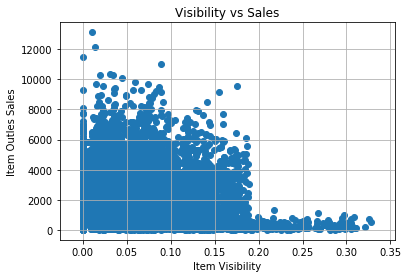

In [16]:
ds = dataset[['Item_Visibility','Item_Outlet_Sales']].sort_values('Item_Visibility', ascending=True)

fig, ax = plt.subplots()
ax.scatter(ds['Item_Visibility'],ds['Item_Outlet_Sales'])
ax.set(xlabel='Item Visibility',ylabel='Item Outles Sales',title='Visibility vs Sales')
ax.grid()
plt.show()

<b> Outlet Age vs Sales </b>
<br> How does item sales vary with Outlet Age?
<br> Again no clear trend. The sales stays alomost flat. The sharp dip is due to the fact that no store falls under that age range. It shoots up around 25 but what to conclude from it??

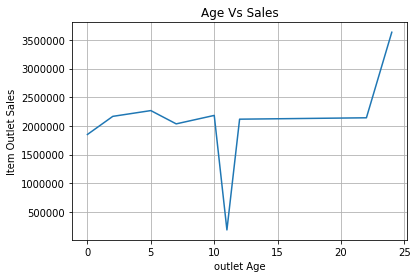

In [17]:
#ds = dataset[['outlet_age','Item_Outlet_Sales']].sort_values('outlet_age',ascending=True)
ds = dataset.groupby('outlet_age')['Item_Outlet_Sales'].sum().reset_index().sort_values('outlet_age')
fig, ax = plt.subplots()
ax.plot(ds['outlet_age'],ds['Item_Outlet_Sales'])
ax.set(xlabel='outlet Age',ylabel='Item Outlet Sales',title='Age Vs Sales')
ax.grid()
plt.show()

<b> Sales per store size </b>
<br>
What are sales figures for each store size?
<br> The small size outlets are making 48% the over all thing. 

In [18]:
total_Sales = dataset['Item_Outlet_Sales'].sum()
ds = dataset[['Outlet_Size','Item_Outlet_Sales']].copy()
ds['sales_percent'] = (ds['Item_Outlet_Sales']/total_Sales)*100
ds = ds.groupby('Outlet_Size')['sales_percent'].sum().reset_index().sort_values('sales_percent',ascending=False)
ds.head()

,Outlet_Size,sales_percent
2,Small,48.188278
1,Medium,40.286527
0,High,11.525196


<b> Top selling item per location type </b>
<br>
What is the top selling item at each of the location type?

In [19]:
idx = dataset['Item_Outlet_Sales'] == dataset.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].transform(max)
dataset[idx][['Outlet_Location_Type','Item_Identifier','Item_Outlet_Sales']].sort_values('Item_Outlet_Sales',
                                                                                         ascending=False).head()

,Outlet_Location_Type,Item_Identifier,Item_Outlet_Sales
7188,Tier 3,NCE42,13086.9648
4289,Tier 1,NCM05,9779.9362
4961,Tier 2,FDK03,9664.7528


## Data Scrubbing 
For the lack of a better word I am calling the following operation as Data Scrubbling operation. By doing this we will convert our data into a form which can be fed to a machine learning model. Here is a list of operations we will perfrom
<br> 1) <b>Drop identifiers</b> : we will drop Item_identifier and Outlet_identifier column as they are of no use for a machine Learning model.
<br> 2) <b> Normalization </b> : we will normalized the Item_weight,Item_MRP, and Outlet_age columns so that they do not dominate the other categorical features
<br> 3) <b> Digitization </b> : for thr Item_Fat_content column let's map 'Low Fat' to 0 and 'Regular' to 1
<br> 4) <b> Dummy features </b> : Lastly we will convert the Item Type, Outlet_size, Outlet_loc, and outlet_location_type to one hot vectors.

In [20]:
dataset = dataset.drop(columns=['Item_Identifier','Outlet_Identifier'])

max_weight = dataset['Item_Weight'].max()
min_weight = dataset['Item_Weight'].min()
dataset['Item_Weight'] = (dataset['Item_Weight']- min_weight)/(max_weight-min_weight)

max_mrp = dataset['Item_MRP'].max()
min_mrp = dataset['Item_MRP'].min()
dataset['Item_MRP'] = (dataset['Item_MRP']-min_mrp)/(max_mrp-min_mrp)

max_age = dataset['outlet_age'].max()
min_age = dataset['outlet_age'].min()
dataset['outlet_age'] = (dataset['outlet_age']-min_age)/(max_age-min_age)

dataset['Item_Fat_Content'] = dataset['Item_Fat_Content'].map({'Low Fat':0,'Regular':1})

item_type_dummy = pd.get_dummies(dataset['Item_Type'],prefix='item_type')
outlet_size_dummy = pd.get_dummies(dataset['Outlet_Size'],prefix='Outlet_Size')
outlet_loc_dummy = pd.get_dummies(dataset['Outlet_Location_Type'],prefix='Outlet_Location_Type')
outlet_type_dummy = pd.get_dummies(dataset['Outlet_Type'],prefix='Outlet_Type')

dataset = pd.concat((dataset,item_type_dummy,outlet_size_dummy,outlet_loc_dummy,outlet_type_dummy),axis=1)

dataset = dataset[['Item_Weight','Item_Fat_Content','Item_Visibility','item_type_Baking Goods','item_type_Breads',
                  'item_type_Breakfast','item_type_Canned','item_type_Dairy','item_type_Frozen Foods',
                  'item_type_Fruits and Vegetables','item_type_Hard Drinks','item_type_Health and Hygiene',
                 'item_type_Household','item_type_Meat','item_type_Others','item_type_Seafood','item_type_Snack Foods',
                 'item_type_Soft Drinks','item_type_Starchy Foods','Item_MRP','outlet_age','Outlet_Size_High',
                 'Outlet_Size_Medium','Outlet_Size_Small','Outlet_Location_Type_Tier 1','Outlet_Location_Type_Tier 2',
                 'Outlet_Location_Type_Tier 3','Outlet_Type_Grocery Store','Outlet_Type_Supermarket Type1',
                 'Outlet_Type_Supermarket Type2','Outlet_Type_Supermarket Type3','Item_Outlet_Sales']]

Let's Save the ready to Train data as new CSV file.

In [118]:
dataset.to_csv('ready_to_train.csv',sep=',',index=False)

## Training 
Ready to train!

In [3]:
dataset = pd.read_csv('ready_to_train.csv')
#dataset = pd.read_csv('car_sales.csv')
dataset.head(10)

,Item_Weight,Item_Fat_Content,Item_Visibility,item_type_Baking Goods,item_type_Breads,item_type_Breakfast,item_type_Canned,item_type_Dairy,item_type_Frozen Foods,item_type_Fruits and Vegetables,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,0.282525,0,0.016047,0,0,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,3735.1380
1,0.081274,1,0.019278,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,443.4228
2,0.770765,0,0.016760,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,2097.2700
3,0.871986,1,0.000000,0,0,0,0,0,0,1,...,0,1,0,0,1,1,0,0,0,732.3800
4,0.260494,0,0.000000,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,994.7052
5,0.347723,1,0.000000,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,556.6088
6,0.541530,1,0.012741,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,343.5528
7,0.544935,0,0.127470,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,4022.7636
8,0.693361,1,0.016687,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,0,1076.5986
9,0.871986,1,0.094450,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,0,4710.5350


### Base Model
let's start by building a base model. This model does no learning. it just look at the item type and outlet type for a record and returns as prediction the avarage sales value corresponding to that item type and outlet type from the training data. We will use the RMSE score for this model as base line for comparing the other learning models. the idea is - if the model we build give RMSE score more them that of the Base Model then we have done something worng with the model.

In [4]:
train_ds,test_ds = train_test_split(dataset,test_size =0.2)
baseMod = baseModel(train_ds)

In [20]:
arr = train_ds.values
X = arr[0:100,0:-1]
y = arr[0:100,-1].reshape(-1,1)
y_hat = baseMod.predict(X)
data = np.hstack((y_hat,y))
out_ds = pd.DataFrame(data=data,columns=['y-hat','y'])
print(out_ds.head(10))

         y-hat          y
0  1937.959912  2175.8344
1  2446.626674  1653.8472
2  2218.256373  3235.7880
3  2108.662578  3149.2340
4  2064.126476  1922.8304
5  2325.432436  7590.1200
6  2218.256373  1054.6272
7  2400.577293  3563.3616
8   315.046047   420.7856
9  3453.678287  5219.8720


In [19]:
rmse_test = baseMod.score(test_ds)
print('test RMSE:',rmse_test)

test RMSE: [1466.24061281]


### Linear Regression
the first model we will build is simple linear regression. 

In [22]:
linreg = LinearRegression()

training for lr: 0.6
iteration  0 / 100  loss: [3792719.51478485]
iteration  10 / 100  loss: [1256918.70160842]
iteration  20 / 100  loss: [804105.63064899]
iteration  30 / 100  loss: [697288.49478716]
iteration  40 / 100  loss: [663904.43304574]
iteration  50 / 100  loss: [650551.38487735]
iteration  60 / 100  loss: [644326.38930531]
iteration  70 / 100  loss: [641169.27718274]
iteration  80 / 100  loss: [639480.53346855]
iteration  90 / 100  loss: [638538.31689255]


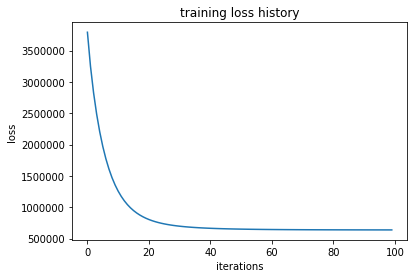

lowest train rmse: [1129.59468097]  acheived for lr: 0.6
lowest test rmse: [1129.59468097]  acheived for lr: 0.6


In [23]:
num_iter = 100
learning_rate = np.array([0.6])#((1e-8,1e-7,0.1e-6))
verbose = True
print_every = 10
test_size = 0.2
train_ds,test_ds = train_test_split(dataset,test_size =test_size)
best_w = []
best_lr = 0.0

best_w = linreg.fit(train_ds,10,0.0,print_every,verbose=False)
best_rmse = linreg.score(train_ds,best_w)

for lr in learning_rate:
    print('training for lr:',lr)
    w = linreg.fit(train_ds,num_iter,lr,print_every,verbose)
    rmse = linreg.score(train_ds,w)
    if rmse < best_rmse:
        best_rmse = rmse
        best_w = w
        best_lr = lr
test_rmse = linreg.score(train_ds,w)
print('lowest train rmse:',best_rmse,' acheived for lr:',best_lr)
print('lowest test rmse:',test_rmse,' acheived for lr:',best_lr)

The RMSE score we got from the Simple linear regression is less than that from Base Model so we are directionally correct. The Linear regression model is an improvement over the Base Model

In [24]:
arr = train_ds.values
X = np.hstack((np.ones((arr.shape[0],1)),arr[:,0:-1]))
y = arr[:,-1].reshape(-1,1)
y_hat = linreg.predict(X,best_w)
data = np.hstack((y_hat,y))
out_ds = pd.DataFrame(data=data,columns=['y-hat','y'])
print(out_ds.head(10))

         y-hat          y
0  3195.660919  2946.1650
1  1758.443139  2376.9060
2  3079.767117  4028.0900
3  2979.065063  2999.4290
4  3192.624195  3153.2288
5  -803.832001    65.2484
6  2204.438617   529.9768
7  1046.250983  1853.5872
8  3687.566561  4580.7040
9  2094.801020  1102.5648


### Treditional Linear Regression
For this probelem set I also wanted to simulate the linear regression we do treditionally from tools such as XL and SPSS and compare the result with our linear regression model. The treditional approach is a bit different from how we have implemented Linear Regression in our code.
<br>
<br>
1) <b>Nomal Equation: </b> In treditional LR we derive the coefficients directly by using Normal equation. While in our implementation above we did SGD for finding the model coeff which gives minimun RMSE
<br>
<br>
2) <b> Infrential Statistics: </b> in our implementation of Linear regression we divided the training data in train and validation set (we are calling it test set here but its actually is validation set). We used the validation set to pick the best model. In treditional method we use infrential statistical tools such as:
<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a)<b>ANOVA</b> Analysis of Variance test(ANOVA) is used to gage the overall signficance of the model. If the P-value corresponding to the F Statistics is less then 0.05 then we can infer that our model is overall significant.
<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a)<b>T-test for coefficeints</b> The significance of each coefficient is checked by runing a T-test and looking at the P-Values. if you look at the result below you will notice that the P-Value is more then the critical threshold of 0.05 and hence those feature are not significant. But i don't want to delve too much on this values as i haven't captured the effect of Multicolliniarity b/w the features. The reason is that my goal is to build a model that gives lowest RMSE and not to find which feature contibutes how much towards acheiving this goal.

In [6]:
linReg = ClassicLinearRegression()

Classic Linear Regression Object created


In [7]:
#dataset = pd.read_csv('car_sales.csv')
#data = {'x1':[18,25,15,22,24,20],'y':[45,58,50,54,62,53]}
#dataset = pd.DataFrame.from_dict(data)
test_size = 0.2
train_ds,test_ds = train_test_split(dataset,test_size =test_size)
train_ds.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,item_type_Baking Goods,item_type_Breads,item_type_Breakfast,item_type_Canned,item_type_Dairy,item_type_Frozen Foods,item_type_Fruits and Vegetables,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
4419,0.178327,0,0.027324,0,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,1837.6080
654,0.490920,0,0.076060,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,0,0,868.8690
7516,0.545005,1,0.038314,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,4504.1370
1831,0.627865,1,0.099839,0,0,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,1733.7432
269,0.663590,0,0.045166,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,2516.7240


In [8]:
test_size = 0.0
train_ds,test_ds = train_test_split(dataset,test_size =test_size)
b_hat = linReg.fit(train_ds)
print('b_hat',b_hat)

b_hat [ 5.66199697e+02 -2.84727864e+00  4.03443672e+01 -3.02436646e+02
  2.93234621e+01  3.52001173e+01  3.64267248e+01  5.62433736e+01
 -1.13918575e+01  1.64963324e+00  5.86585605e+01  2.79127738e+01
  1.74580464e+01 -9.55310418e+00  2.97430521e+01  6.31671376e+00
  2.15349774e+02  1.87738323e+01  1.98638916e+00  5.21022057e+01
  3.66867228e+03 -7.45321328e+02  6.85804446e+02 -4.25312287e+01
 -7.70735199e+01  3.85527462e+02  2.16940105e+02 -3.62678704e+01
 -1.48166997e+03  3.40912156e+01 -2.29231153e+02  2.24300960e+03]


In [11]:
linReg.regressionOutput(train_ds,b_hat)

----------------------
Regression Statistics
----------------------
Multiple R: 0.7505
R Square: 0.5633
Adjusted R Sqaure: 0.5617
Standard Error of Regression: 1129.829
observations: 8523
----------------------
---------------------------------------------------------------------------
ANOVA
---------------------------------------------------------------------------
              DF            SS           MS        F Significance F
                                                                   
Regression    31  1.397839e+10  4.50916e+08  353.282              0
Residual    8492  1.083888e+10  1.27636e+06                        
Total       8523  2.481727e+10                                     
---------------------------------------------------------------------------
----------------------
Covariance Matrix
----------------------
[[ 1.5415e+04 -6.4053e+02 -1.4842e+02 ... -1.0478e+04 -4.9273e+03
   2.5089e+04]
 [-6.4053e+02  2.4004e+03  2.8749e+01 ... -1.1897e+02 -1.2045e+02
  -2